In [1]:
## Instalaciones
%pip install pandas
%pip install seaborn
%pip install matplotlib
%pip install plotly
%pip install pytorch
%pip install open3d
%pip install "notebook>=7.0" "anywidget>=0.9.13"


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File

In [2]:
## Dependencias Externas
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib import font_manager
from cycler import cycler
import os
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from random import randrange
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import open3d as o3d
import plotly.graph_objects as go
import warnings

## Depdendencias Internas
from modelnet10 import ModelNetClass, DatasetType, ModelNet
from model import PointNetClassifier
from utils.plotter import notebook_plot_pcd_from_points
from modelnet10 import ModelNetClass, ModelNet, DatasetType
from model import PointNetClassifier, PointNetKAN, PointNetLoss, TTAClassifier
from utils.transformation import (Normalization,
                                  Rotation, Translation, Reflection, Scale,
                                  DropRandom, DropSphere, Jittering, Noise)


## ALgunas variables y constantes importantes
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {DEVICE}.")

sns.set_theme()
sns.set_palette("Set2")

# plt.rcParams["axes.prop_cycle"] = cycler(alpha=[0])
fp = font_manager.FontProperties(fname="plots/FiraSans-Regular.ttf")
font_manager.fontManager.addfont("plots/FiraSans-Regular.ttf")
plt.rcParams["font.family"] = fp.get_name()

ROOT_DIR = os.getcwd()

warnings.filterwarnings('ignore')

/home/antonioskorin/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using cpu.


## Presentación y Visualización del ModelNet10

### Declaración de funciones y constantes

In [34]:
## Parametros y constantes para la visualización
BEST_MODEL_DIR = os.path.join(ROOT_DIR, "checkpoint", "best_model")

# Clases del ModelNet10
classes = [label for label in ModelNetClass]
dim = 3
num_points = 1024
num_classes = len(classes)
num_global_feats = 1024


In [45]:
## Inicialización de objetos y funciones para la visualización

def map_label(num):
    return classes[num].label

def prettier(string):
    return string.replace("_", " ").capitalize()

def predicted_class(pcd, cls):
    out, _, _ = cls(pcd)
    pred_choice = torch.softmax(out, dim=1).argmax(dim=1)
    return map_label(pred_choice)

def random_sample(data):
    index = randrange(data.__len__())
    _return = data.__getitem__(index)
    return _return[0].transpose(1, 0), _return[1]

def pcd_path_to_tensor(pcd_path):
    X = list()
    pcd = o3d.io.read_point_cloud(pcd_path)
    points = np.asarray(pcd.points, dtype=float)
    X.append(points)
    X = np.transpose(X, (0, 2, 1))
    X = torch.tensor(X, dtype=torch.float32)

    return X

In [46]:
def visualize_random_point_cloud(data, output_plot, output_text, cls=None):
    with output_plot:
        clear_output(wait=True)

        # Selección aleatoria
        x, label = random_sample(data)

        # Visualización
        notebook_plot_pcd_from_points(x, output_size=(1000,400), zoom=1.0)

        # Predicción y formato
        if cls:
            x = x.unsqueeze(0)
            x = x.transpose(1, 2)
            cls = cls.eval()
            
            pred = predicted_class(x, cls)
            match = (pred == label)
            color = "#2ECC40" if match else "#FF4136"
            print(pred)
            pred = prettier(pred)
            label = prettier(map_label(label))

            with output_text:
                clear_output(wait=True)
                display(HTML(f"""
<div style="font-size: 20px; font-family: Arial, sans-serif; border: 1px solid #ccc; padding: 15px; border-radius: 10px; background-color: #f9f9f9; width: fit-content;">
  <div><strong style="color: #444;">Ground Truth:</strong> <span style="color: {color};">{label}</span></div>
  <div><strong style="color: #444;">Predicted Class:</strong> <span style="color: {color};">{pred}</span></div>
</div>
"""))
        else:
            color = "#00008B"
            label = prettier(map_label(label))

            with output_text:
                clear_output(wait=True)
                display(HTML(f"""
<div style="font-size: 20px; font-family: Arial, sans-serif; border: 1px solid #ccc; padding: 15px; border-radius: 10px; background-color: #f9f9f9; width: fit-content;">
  <div><strong style="color: #444;">Class:</strong> <span style="color: {color};">{label}</span></div>
</div>
"""))

In [28]:
# Dataset sin transformar
data_train_original = ModelNet(classes, DatasetType.TRAIN, repetitions=0, transformations=[], normalize=False, preserve_original=True)
data_valid_original = ModelNet(classes, DatasetType.VALIDATION, repetitions=0, transformations=[], normalize=False, preserve_original=True)

# Dataset con transformaciones
t = [Rotation(), Reflection(), Scale(max_ratio=3.0),
     Jittering(max_units=0.005), DropRandom(loss_ratio=0.4), Noise()]
data_train_aug = ModelNet(classes, DatasetType.TRAIN, repetitions=3, transformations=t, normalize=False, preserve_original=False)

### Visualización del set de entrenamiento
A continuación se visualiza el dataset de entrenamiento aumentado y original, a través de un visualizador interactivo.

In [47]:
def bind_button_to_dataset(dataset, cls=None):
    # Widgets de output
    button = widgets.Button(description="Generar ejemplo")
    output_plot = widgets.Output()
    output_text = widgets.Output()
        
    button._click_handlers.callbacks.clear()
    output_plot.clear_output()
    output_text.clear_output()

    def on_button_click(b):
        visualize_random_point_cloud(dataset, output_plot, output_text, cls)

    button.on_click(on_button_click)
    on_button_click(None)
    
    return widgets.VBox([button, output_plot, output_text])

vis_output = widgets.Output()
selector = widgets.Dropdown(
    options=["original", "aumentado"],
    description="Dataset:",
    value="original"
)

def on_select_change(change):
    with vis_output:
        clear_output(wait=True)
        dataset = {
            "original": data_train_original,
            "aumentado": data_train_aug
        }[change["new"]]
        display(bind_button_to_dataset(dataset, None))


selector.observe(on_select_change, names="value")

# Initial display
with vis_output:
    clear_output(wait=True)
    display(bind_button_to_dataset(data_train_original))

# Render full UI
ui = widgets.VBox([selector, vis_output])
display(ui)

# Trigger once manually
on_select_change({"new": selector.value})


### Estadísticas del Dataset

A continuación se muestra la frecuencia de clases del dataset de entrenamiento

In [8]:
data = {
    "label": list(),
    "train_freq": list(),
    "test_freq": list()
}
    
for label in classes:
    data["label"].append(label.label)
    data["train_freq"].append(label.train_size)
    data["test_freq"].append(label.test_size)
    

df = pd.DataFrame(data = data)
df

,label,train_freq,test_freq
0,bathtub,106,50
1,bed,515,100
2,chair,889,100
3,desk,200,86
4,dresser,200,86
5,monitor,465,100
6,night_stand,200,86
7,sofa,680,100
8,table,392,100
9,toilet,344,100


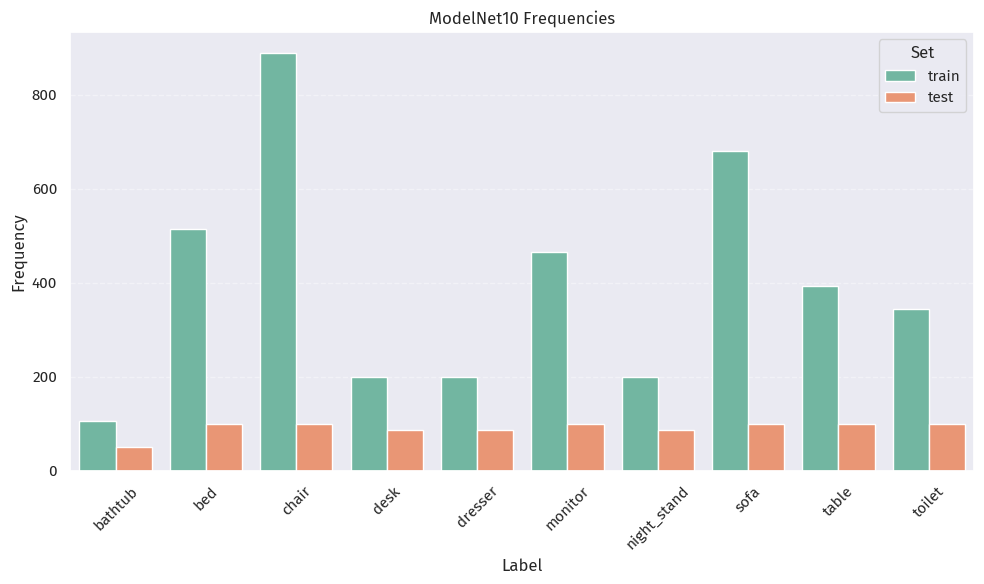

In [9]:
df_long = df.melt(id_vars='label', var_name='split', value_name='freq')
df_long['set'] = df_long['split'].str.replace('_freq', '')
plt.figure(figsize=(10, 6))
sns.barplot(data=df_long, x='label', y='freq', hue='set')

plt.title("ModelNet10 Frequencies")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title='Set')
plt.show()    

También podemos visualizar las cajas delimitadoras de los objetos (alineadas con los ejes), esto nos da una idea de la distribución.

In [10]:
order_corners = [
    {"l", "f", "bo"},   # 0
    {"r", "f", "bo"},   # 1
    {"l", "ba", "bo"},  # 2
    {"l", "f", "t"},    # 3
    {"r", "ba", "t"},   # 4
    {"l", "ba", "t"},   # 5
    {"r", "f", "t"},    # 6
    {"r", "ba", "bo"},  # 7
]

edges = []
for i in range(len(order_corners)):
    for j in range(i + 1, len(order_corners)):
        if len(order_corners[i].intersection(order_corners[j])) == 2:
            edges.append((i, j))



def plot_bounding_boxes_from_tensor(pcd_tensor: torch.Tensor, color, filename=None):
    assert pcd_tensor.ndim == 3 and pcd_tensor.shape[2] == 3, "Expected shape (B, N, 3)"

    fig = go.Figure()

    for i in range(pcd_tensor.shape[0]):
        points = pcd_tensor[i].cpu().numpy()

        # Open3D PCD
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)

        obb = pcd.get_axis_aligned_bounding_box()
        corners = np.asarray(obb.get_box_points())  # shape (8, 3)
        
        
        # Generar coordenadas de líneas
        x_lines, y_lines, z_lines = [], [], []
        for i0, i1 in edges:
            x_lines.extend([corners[i0, 0], corners[i1, 0], None])
            y_lines.extend([corners[i0, 1], corners[i1, 1], None])
            z_lines.extend([corners[i0, 2], corners[i1, 2], None])

        fig.add_trace(go.Scatter3d(
            x=x_lines, y=y_lines, z=z_lines,
            mode='lines',
            line=dict(color=color, width=4),
            name=f'OBB {i}'
        ))

    fig.update_layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=10, r=10, t=10, b=10),  # minimal margins in pixels
        autosize=True,
        scene=dict(
            xaxis=dict(visible=True),
            yaxis=dict(visible=True),
            zaxis=dict(visible=True),
            aspectmode='data'
        ),
        showlegend=False
    )
    
    fig.show()

    if filename:
        fig.write_image(filename, format="png")


def plot_mean_aabb(pcd_tensor: torch.Tensor, color, filename=None):
    min_bounds, max_bounds = [], []

    for i in range(pcd_tensor.shape[0]):
        points = pcd_tensor[i].cpu().numpy()
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)

        aabb = pcd.get_axis_aligned_bounding_box()
        min_bounds.append(np.asarray(aabb.get_min_bound()))
        max_bounds.append(np.asarray(aabb.get_max_bound()))

    mean_min = np.mean(min_bounds, axis=0)
    mean_max = np.mean(max_bounds, axis=0)

    # Reconstruct AABB from averaged bounds
    mean_aabb = o3d.geometry.AxisAlignedBoundingBox(min_bound=mean_min, max_bound=mean_max)
    corners = np.asarray(mean_aabb.get_box_points())

    x_lines, y_lines, z_lines = [], [], []
    for i0, i1 in edges:
        x_lines.extend([corners[i0, 0], corners[i1, 0], None])
        y_lines.extend([corners[i0, 1], corners[i1, 1], None])
        z_lines.extend([corners[i0, 2], corners[i1, 2], None])

    fig = go.Figure(data=[
        go.Scatter3d(
            x=x_lines, y=y_lines, z=z_lines,
            mode='lines',
            line=dict(color=color, width=6),
            name='Mean AABB'
        )
    ])

    fig.update_layout(
        margin=dict(l=10, r=10, t=10, b=10),  # minimal margins in pixels
        autosize=True,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        scene=dict(
            xaxis=dict(visible=True),
            yaxis=dict(visible=True),
            zaxis=dict(visible=True),
            aspectmode='data'
        ),
        showlegend=False
    )
    
    fig.show()

    if filename:
        fig.write_image(filename, format="png")


X_train = torch.transpose(data_train_original._X, 1, 2)
y_train = data_train_original._y

X_valid = torch.transpose(data_valid_original._X, 1, 2)
y_valid = data_valid_original._y

X_train = torch.cat((X_train, X_valid), dim=0)
y_train = torch.cat((y_train, y_valid), dim=0)


In [11]:
# Esto tiene la capacidad de crashear el notebook, descomentarlo si se quiere correr el riesgo.
#plot_bounding_boxes_from_tensor(X_train, "#71b6a1", filename=None)

plot_mean_aabb(X_train, "#71b6a1", filename=None)

Estadísticas sobre las coordenadas de las PCDs:

In [12]:
X_train_coords = X_train.reshape(-1, 3)

X_train_coords_mean = X_train_coords.mean(dim=0)
X_train_coords_std = X_train_coords.std(dim=0)

print("X_train coordinate means: ", X_train_coords_mean)
print("X_train coordinate stds: ", X_train_coords_std)


X_train coordinate means:  tensor([ 4.9587, 12.9201, -0.3267])
X_train coordinate stds:  tensor([1104.9083, 1543.8234,  837.9557])


## Modelos Clasificadores
Las celdas de a continuación muestran todo lo que tiene que ver con los clasificadores entrenados, esto es, curvas de pérdida, accuracy, predicciones sobre sets de testeo originales y aumentados, además de clasificación interactiva.

### Curvas de pérdida y accuracy

In [13]:
CHECKPOINT_DIR = os.path.join(ROOT_DIR, "checkpoint")
CSV_DIR = os.path.join(CHECKPOINT_DIR, "csv")

In [14]:
# Cargamos los csv de los datos de entrenamiento
df_gn = pd.read_csv(os.path.join(CSV_DIR, "gn_loss_dict.csv"))

In [15]:
def filter_df(df, start_epoch, end_epoch, max_display_loss=None, sets=["train", "valid"]):
    df_plot = df[(df['epoch'] >= start_epoch) & (df['epoch'] <= end_epoch) & (df["set"].isin(sets))]
    df_plot = df_plot.copy()
    df_plot['loss'] = df_plot['loss'].clip(upper=max_display_loss)
    return df_plot
    
def plot_metric(df, metric, file_prefix=None, best_model_epoch=None):
    # Loss
    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(data=df, x='epoch', y=metric, hue='set')
    if best_model_epoch:
        x.axvline(483, color='r', linestyle='--')
    
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend(title='Set')
    plt.grid(True)
    plt.tight_layout()
    if file_prefix:
        plt.savefig(f"plots/{name_prefix}_{metric}_per_epoch.pdf", bbox_inches='tight', pad_inches=0, facecolor=(1,1,1,0))
    plt.show()


In [16]:
df_gn = filter_df(df_gn, 1, 300)

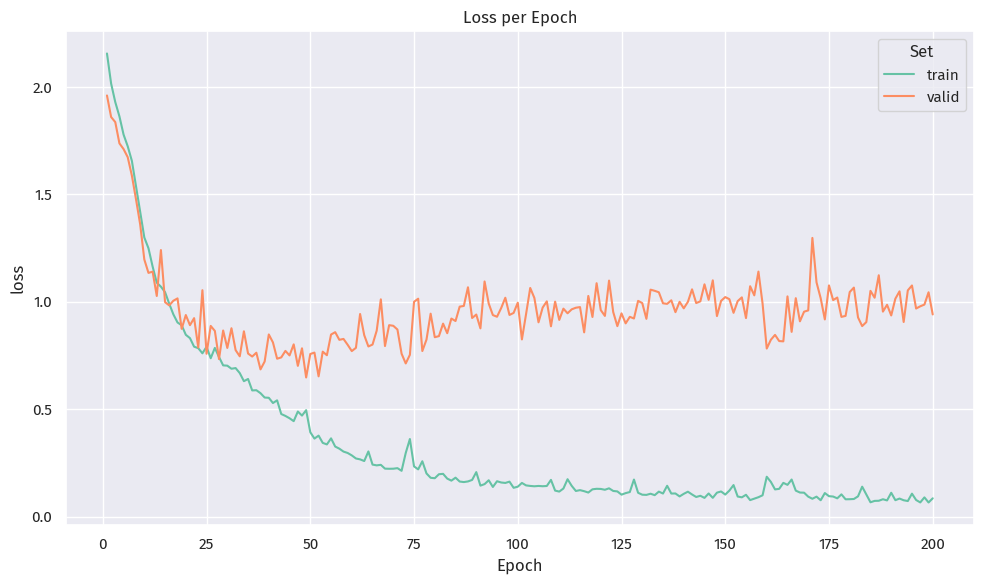

In [17]:
plot_metric(df_gn, "loss")

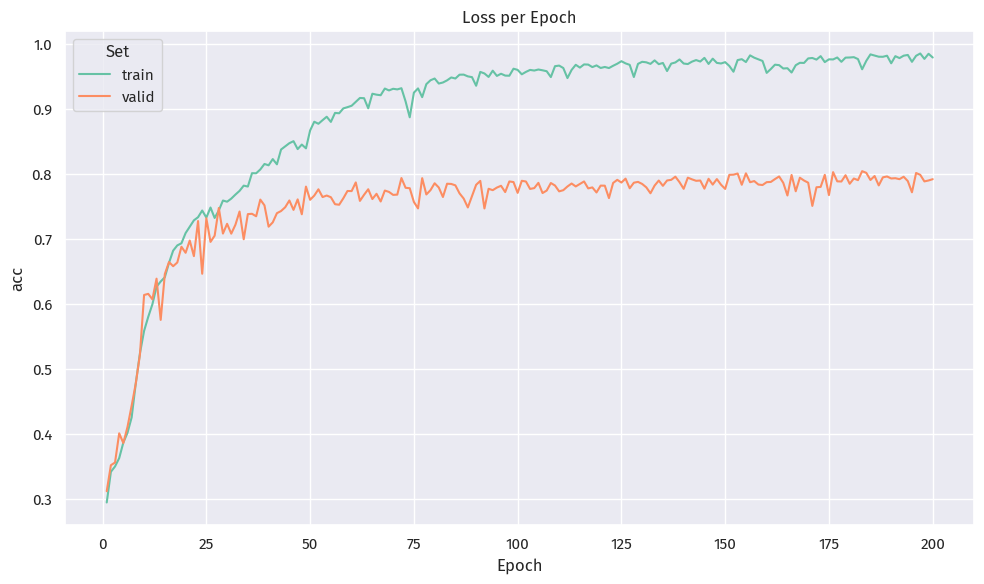

In [18]:
plot_metric(df_gn, "acc")

### Clasificadores sobre el dataset de testeo

#### Overall accuracy, mean Accuracy y matrices de confusión

In [38]:
# Datasets de prueba, todos normalizados

# Dataset no transformado
base_test_data = ModelNet(classes, DatasetType.TEST, repetitions=0, preserve_original=True,
                          transformations=[])

# Transformaciones afines (rotaciones, escalados, reflexiones)
affine_test_data = ModelNet(classes, DatasetType.TEST, repetitions=1, preserve_original=False,
                          transformations=[Rotation(), Reflection(), Scale(max_ratio=2.5)])

# Solo corrupción de puntos (péridida, jitter, noise)
corruption_test_data = ModelNet(classes, DatasetType.TEST, repetitions=1, preserve_original=False,
                                transformations=[Jittering(max_units=0.005), DropRandom(loss_ratio=0.4), Noise()])

# Todas las transformaciones
complex_test_data = ModelNet(classes, DatasetType.TEST, repetitions=1, preserve_original=False,
                          transformations=[Rotation(), Reflection(), Scale(max_ratio=2.5),
                                          Jittering(max_units=0.005), DropRandom(loss_ratio=0.4), Noise()])


In [39]:
BEST_MODEL_DIR = os.path.join(CHECKPOINT_DIR, "best_model")

# algunos parámetros
batch_size = 32
dim = 3
num_points = 1024
num_classes = len(classes)

# del modelo
num_global_feats = 1024     # número de features globales calculadas


def test_it(classifier_path: str, num_global_feats=num_global_feats, use_kan=False,
            ignore_Tnet=False, use_TTA=False, merge_mode=None, norm_type="batchnorm", plot_cm=False, filename=None):

    results = {
        "base":    {"oAcc": 0, "mAcc": 0, "gt": [], "pred": []},
        "affine": {"oAcc": 0, "mAcc": 0, "gt": [], "pred": []},
        "corruption": {"oAcc": 0, "mAcc": 0, "gt": [], "pred": []},
        "complex":{"oAcc": 0, "mAcc": 0, "gt": [], "pred": []}
    }

    datasets = [
        ("base", base_test_data),
        ("affine", affine_test_data),
        ("corruption", corruption_test_data),
        ("complex", complex_test_data)
    ]

    # Load and evaluate each dataset
    for data_name, data in datasets:
        data_loader = DataLoader(data, batch_size=batch_size, shuffle=False)

        classifier_cls = PointNetClassifier if not use_kan else PointNetKAN
        classifier_args = (
            (dim, num_points, num_global_feats, num_classes, ignore_Tnet, norm_type)
            if not use_kan else
            (dim, num_points, num_classes, 1.0, ignore_Tnet)
        )

        classifier = classifier_cls(*classifier_args).to(DEVICE)
        classifier.load_state_dict(torch.load(classifier_path, map_location=torch.device(DEVICE)))

        if use_TTA:
            classifier = TTAClassifier(classifier=classifier, transformations=[Rotation(), Reflection()], merge_mode=merge_mode)

        classifier.eval()
        with torch.no_grad():
            for pcds, labels in data_loader:
                pcds = pcds.to(DEVICE)
                labels = labels.squeeze().to(DEVICE)

                out, _, _ = classifier(pcds)
                if not use_TTA:
                    # Calculamos las elecciones, TTA ya hace softmax.
                    out = torch.softmax(out, dim=1)

                pred_choice = out.argmax(dim=1)
                results[data_name]["gt"]   += list(map(map_label, labels.tolist()))
                results[data_name]["pred"] += list(map(map_label, pred_choice.tolist()))

            gt = results[data_name]["gt"]
            pred = results[data_name]["pred"]
            results[data_name]["oAcc"] = accuracy_score(gt, pred) * 100
            results[data_name]["mAcc"] = balanced_accuracy_score(gt, pred) * 100

            print(f"\toAcc on {data_name} dataset:\t", results[data_name]["oAcc"])
            print(f"\tmAcc on {data_name} dataset:\t", results[data_name]["mAcc"])
            print()

    # Matrices de confusión
    if plot_cm:
        labels_list = [cls.label for cls in classes]

        for data_name in ["base", "affine", "corruption", "complex"]:
            gt = results[data_name]["gt"]
            pred = results[data_name]["pred"]
            cm = confusion_matrix(gt, pred, labels=labels_list)

            plt.figure(figsize=(8, 6))
            ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                             xticklabels=labels_list,
                             yticklabels=labels_list)

            plt.xlabel("Prediction", fontsize=12)
            plt.ylabel("Ground Truth", fontsize=12)
            plt.title(f"Confusion Matrix – {data_name.upper()} Set", fontsize=14)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

            # Show accuracy in lower corner
            oacc = results[data_name]["oAcc"]
            macc = results[data_name]["mAcc"]
            plt.text(
                -3, len(labels_list) + 0.5,
                f"oAcc: {oacc:.2f}%\nmAcc: {macc:.2f}%",
                fontsize=11, ha='left', va='top'
            )

            if filename:
                plt.savefig(f"plots/{filename}_{data_name}.png", bbox_inches='tight', pad_inches=0.2, facecolor=(1,1,1,0))

            plt.show()

In [40]:
# Cargamos el modelo
best_model_path = os.path.join(BEST_MODEL_DIR, "base_best_model.pth")

Con TTA
Sin TTA
	oAcc on base dataset:	 86.23348017621146
	mAcc on base dataset:	 85.06744186046511

	oAcc on affine dataset:	 51.3215859030837
	mAcc on affine dataset:	 51.09069767441861

	oAcc on corruption dataset:	 75.22026431718062
	mAcc on corruption dataset:	 73.92790697674421

	oAcc on complex dataset:	 49.008810572687224
	mAcc on complex dataset:	 47.92790697674419



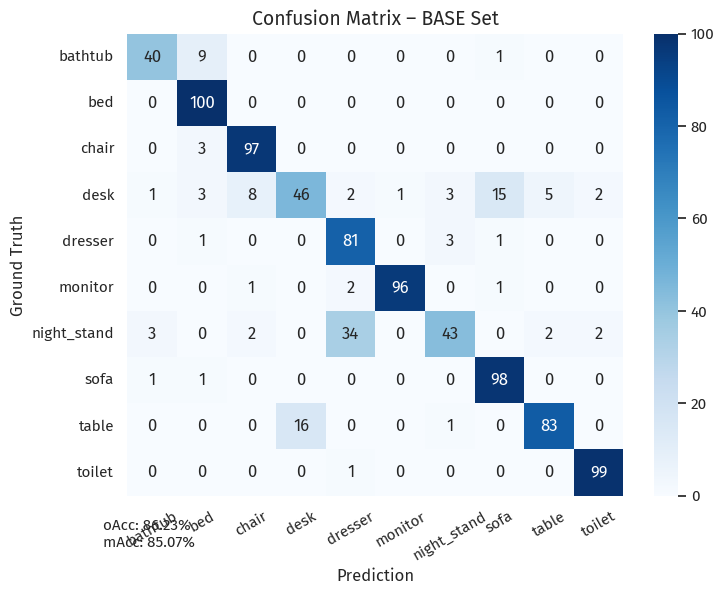

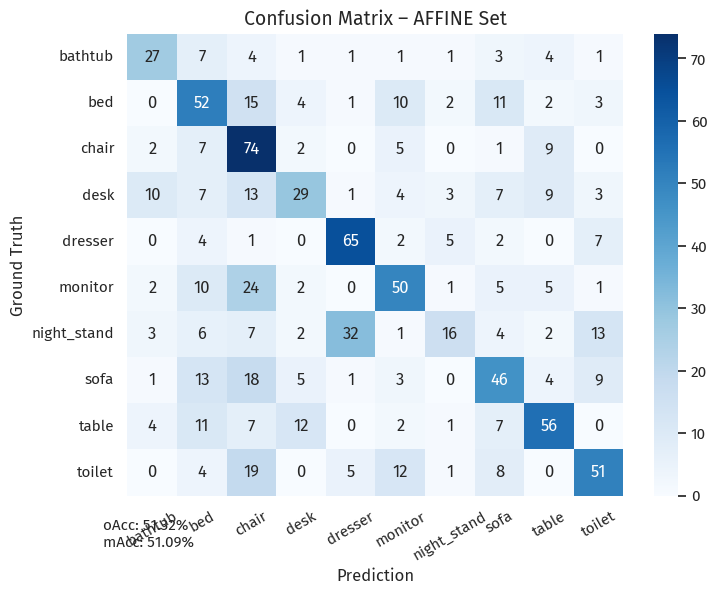

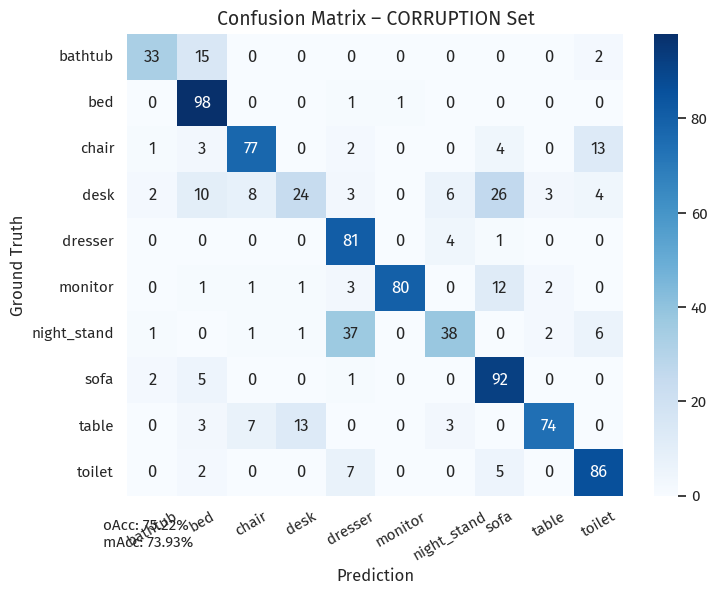

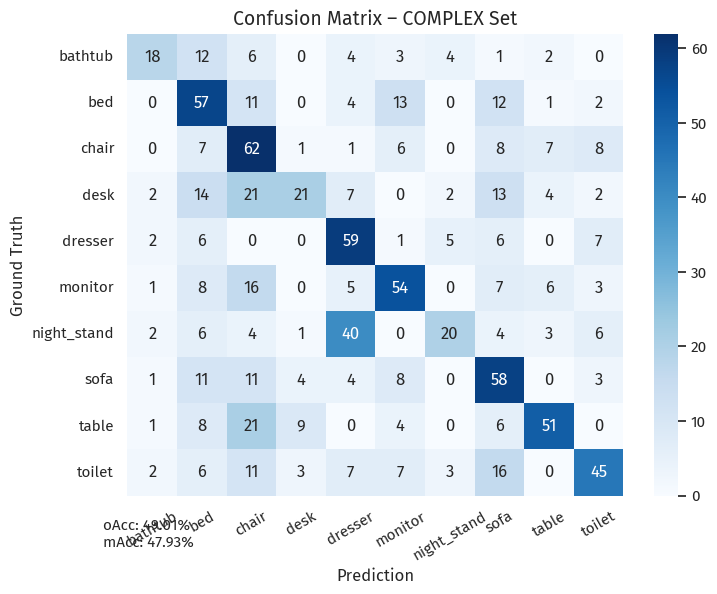

In [97]:
print("Con TTA")
# test_it(best_model_path, norm_type="batchnorm", use_TTA=True, merge_mode="mean", plot_cm=True)

print("Sin TTA")
test_it(best_model_path, norm_type="batchnorm", plot_cm=True)

#### Clasificador interactivo

In [48]:
classifier = PointNetClassifier(dim, num_points, num_global_feats, num_classes, norm_type="batchnorm").to(DEVICE)
classifier.load_state_dict(torch.load(best_model_path, map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [49]:
vis_output = widgets.Output()
selector = widgets.Dropdown(
    options=["original", "affine", "corruption", "complex"],
    description="Dataset:",
    value="original"
)

def on_select_change(change):
    with vis_output:
        clear_output(wait=True)
        dataset = {
            "original": base_test_data,
            "affine": affine_test_data,
            "corruption": corruption_test_data,
            "complex": complex_test_data
        }[change["new"]]
        display(bind_button_to_dataset(dataset, classifier))

selector.observe(on_select_change, names="value")

# First render
with vis_output:
    clear_output(wait=True)
    display(bind_button_to_dataset(base_test_data, classifier))

ui = widgets.VBox([selector, vis_output])
display(ui)

# Optional trigger
on_select_change({"new": selector.value})